In [1]:
import sys, os 
current_dir = os.getcwd()
path = os.path.dirname(current_dir)
sys.path.append(path)

from ml_workflow import (TunedEstimator, 
                        PreProcessPipeline, 
                        DateBasedCV
                        )

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd 

In [2]:
X,y = make_regression(n_samples=10000, n_features=15, random_state=42)
X = pd.DataFrame(X)

# Create fake dates - simulating 24 months of data
np.random.seed(42)
n_months = 24
samples_per_month = len(X) // n_months

# Generate dates: YYYYMM format (e.g., 202001, 202002, ...)
dates = []
for month in range(1, n_months + 1):
    year = 2025 + (month - 1) // 12
    mon = ((month - 1) % 12) + 1
    date_value = year * 100 + mon  # e.g., 202001, 202002, etc.
    dates.extend([date_value] * samples_per_month)

# Handle any remaining samples
remaining = len(X) - len(dates)
if remaining > 0:
    dates.extend([dates[-1]] * remaining)

dates = np.array(dates)

### Setting up a Pre-processing Pipeline 

In [3]:
# ============================================================================
# ML Pipeline Configuration
# ============================================================================
# A pipeline chains together preprocessing steps with your ML model into a 
# single object. This ensures that:
#   1. Training data is transformed consistently
#   2. The same transformations are automatically applied during prediction
#   3. All preprocessing parameters are saved with the model
#   4. You avoid data leakage by applying transforms within cross-validation
#
# Think of it as: Raw Data → Impute → Scale → Transform → Model → Prediction
#
# Setting pipeline_kwargs = None skips all preprocessing and uses the raw model.
# ============================================================================

pipeline_kwargs = dict(
    # --- Missing Data Handling ---
    # How to handle NaN/missing values in your features
    imputer='simple',  # Options: None, 'simple' (median/mean fill), 
                       #          'iterative' (predict from other features)
    
    # --- Feature Scaling ---
    # Normalize features to similar ranges (important for many ML algorithms)
    scaler='standard',  # Options: None, 'standard' (zero mean, unit variance),
                        #          'minmax' (scale to [0,1]), 
                        #          'robust' (resistant to outliers)
    
    # --- Dimensionality Reduction ---
    # Reduce feature space using Principal Component Analysis
    pca=False,  # Options: True (apply PCA), False (keep all features)
    
    # --- Class Imbalance Handling ---
    # Artificially balance classes by over/under-sampling
    # ⚠️  WARNING: Resampling changes class distributions and requires 
    #    probability calibration afterward to get reliable predictions!
    # Set to None for regression prediction. 
    
    resample=None,  # Options: None, 'over' (duplicate minority class),
                    #          'under' (remove majority class samples)
    
    # --- Feature Type Specification ---
    # Specify feature types for appropriate preprocessing
    # (e.g., don't scale categorical features like zip codes)
    numeric_features=None,      # List of numeric feature names, or None (all numeric)
    categorical_features=None,  # List of categorical feature names, or None (none)
)

## Hyperparameter Optimization 


In [10]:
def mse_scorer(estimator, X, y):
    pred = estimator.predict(X)
    return mean_squared_error(y, pred)

# ============================================================================
# Cross-Validation Strategy for Temporal Data
# ============================================================================
# For weather/climate data, random splits violate temporal independence due to:
#   1. Temporal autocorrelation (today's weather ~ yesterday's weather)
#   2. Spatial autocorrelation (nearby locations have similar conditions)
#
# Solution: Use date-based splits to prevent "future information leakage"
# into the training set. This ensures realistic evaluation where the model
# is trained on past data and tested on future data.
#
# ============================================================================

cv = DateBasedCV(
    n_splits=5,          # Number of train/validation splits
    dates=dates,          # Array of dates for each sample (e.g., YYYYMMDD)
    valid_size=0.25       # Use 25% of unique dates for validation
                          # (can also be integer: number of dates)
)

# Visualize what the splits look like:
print(f"CV Configuration:")
print(f"  - Total folds: {cv.n_splits}")
print(f"  - Validation dates per fold: {cv.valid_size}")
print(f"  - Training dates per fold: {cv.train_size}")
print(f"  - Unique dates in dataset: {len(np.unique(dates))}")


# ============================================================================
# Hyperparameter Optimization Configuration
# ============================================================================
# This dictionary configures the hyperparameter search process.
# Think of this as exploring different "knob settings" on your model to
# find the combination that produces the best predictions.
# ============================================================================

hyperopt_kwargs = dict(
    # --- Search Space Definition ---
    # Each parameter is given a list of values to try.
    # The optimizer will test different combinations to find the best.
    search_space={
        # Controls how much the model learns from each boosting round
        # Lower = more conservative, higher = faster learning (but may overfit)
        'learning_rate': [0.01, 0.05, 0.1],
        
        # Number of boosting rounds (trees to build)
        # More iterations = more complex model, but takes longer to train
        'max_iter': [100, 200, 300],
        
        # Maximum depth of each tree
        # Deeper = can capture more complex patterns (but may overfit)
        # None = unlimited depth
        'max_depth': [5, 10, None],
        
        # Maximum number of leaves per tree (alternative to max_depth)
        # More leaves = more complex individual trees
        'max_leaf_nodes': [31, 63],
        
        # L2 regularization strength (Ridge penalty on leaf values)
        # Higher = more regularization = less overfitting
        'l2_regularization': [0.0, 0.1, 1.0],
    },
    
    # --- Optimization Strategy ---
    # How to explore the search space:
    #   - "random_search": Randomly sample configurations (fast, good baseline)
    #   - "grid_search": Try all combinations (thorough but slow)
    #   - "tpe": Bayesian optimization [Tree Parzen] (smart, efficient for large spaces)
    #   - "atpe": Adaptive TPE (adjusts during optimization)
    optimizer="tpe",
    
    # --- Budget and Early Stopping ---
    # Maximum number of hyperparameter configurations to evaluate
    # More evaluations = better chance of finding optimal settings
    # Rule of thumb: 10-50 for random search, 50-200 for Bayesian methods
    max_evals=5,  # Increase to 20-50 for real experiments
    
    # Early stopping patience (only for 'tpe'/'atpe' optimizers)
    # Stops if no 1% improvement in validation score for this many iterations
    # Saves time when optimization has plateaued
    patience=10,
    
    # --- Scoring and Evaluation ---
    # Scoring function to optimize (must return lower-is-better values)
    # The optimizer will try to MINIMIZE this score
    scorer=mse_scorer,
    
    # --- Parallelization ---
    # Number of parallel jobs for cross-validation
    # ⚠️ WARNING: Set n_jobs=1 if your estimator already uses parallelization
    #   (e.g., RandomForest with n_jobs=-1) to avoid thread conflicts
    # For HistGradientBoosting: safe to use n_jobs > 1 since it's single-threaded
    n_jobs=1,  # Try n_jobs=-1 (all CPUs) for faster optimization
    
    # --- Cross-Validation Strategy ---
    # Use our custom date-based CV to prevent temporal leakage
    cv=cv,
    
    # --- Results Logging ---
    # Save optimization history to CSV for later analysis
    # Useful for: plotting convergence, analyzing parameter importance
    output_fname="hyperparam_results.csv"
)


# ============================================================================
# Quick Reference: Choosing Optimizer Strategy
# ============================================================================
# 
# Use "random_search" when:
#   ✓ You have a small search space (< 100 combinations)
#   ✓ You want fast initial results
#   ✓ You're doing quick prototyping
#
# Use "grid_search" when:
#   ✓ You have very few parameters to tune
#   ✓ You want to exhaustively test all combinations
#   ✓ Computational cost is not a concern
#
# Use "tpe" (Bayesian optimization) when:
#   ✓ You have a large search space
#   ✓ Evaluations are expensive (slow model training)
#   ✓ You want the most efficient optimization
#   ✓ You can afford 50+ evaluations
#
# Use "atpe" when:
#   ✓ Same as TPE, but for very large/complex spaces
#   ✓ You want adaptive exploration vs exploitation
# ============================================================================


# ============================================================================
# Pro Tips for Weather/Climate ML
# ============================================================================
# 
# 1. ALWAYS use temporal CV for time-series data (like DateBasedCV)
#    Random CV will give artificially optimistic results!
#
# 2. Consider spatial blocking too if you have spatial autocorrelation
#    (train on some regions, validate on others)
#
# 3. For operational forecasting, use "expanding window" CV:
#    Train on all past data, validate on next time period
#
# 4. Monitor both training and validation metrics to detect overfitting
#
# 5. Save your hyperparameter search results! They provide insights:
#    - Which parameters matter most?
#    - Is your model sensitive to certain settings?
#    - Have you explored enough configurations?
# ============================================================================

CV Configuration:
  - Total folds: 5
  - Validation dates per fold: 6
  - Training dates per fold: 18
  - Unique dates in dataset: 24


## Calibration (only for classification models)

In [11]:
# Define calibration method 
# NOTE: Only define if performing classification; 
# no method exists for regression calibration at the moment. 
calibration_cv_kwargs = None

## Fit the model 

In [12]:
%%time
# Note: always initialize your sklearn estimators with a random state 
# for controlled experiments!
estimator = HistGradientBoostingRegressor(random_state=30) 
tuned_estimator = TunedEstimator(estimator, 
                                 pipeline_kwargs,
                                 hyperopt_kwargs,
                                 calibration_cv_kwargs,
                                )
tuned_estimator.fit(X,y)#, groups=groups)

  0%|                                                                                                                                                          | 0/5 [00:00<?, ?trial/s, best loss=?]

/data3/mflora/miniforge3/envs/ml/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.09s/trial, best loss: 703.3478624573368]
CPU times: user 31min 57s, sys: 1.2 s, total: 31min 58s
Wall time: 21.3 s


## Check the Hyperparam Results

In [14]:
df = pd.read_json('hyperparam_results.csv')

In [15]:
df

,loss,loss_variance,iteration,train_time,l2_regularization,learning_rate,max_depth,max_iter,max_leaf_nodes
0,995.110296,4734.429570,1,2.355983,0.0,0.10,5.0,100,31
1,703.347862,2418.791465,2,3.966343,0.1,0.10,5.0,200,31
2,1446.656841,12573.003323,3,7.538664,1.0,0.05,NaN,100,63
3,13488.422349,227871.406609,4,4.056260,0.0,0.01,10.0,100,31
4,993.285990,6522.367808,5,2.514577,0.1,0.10,5.0,100,31


Parameter Importance (Spearman Correlation with Loss):
  learning_rate........................... 0.8944
  max_depth............................... 0.7746
  max_iter................................ 0.7071
  max_leaf_nodes.......................... 0.3536
  l2_regularization....................... 0.2635


Top 2 most impactful parameters:
  1. learning_rate
  2. max_depth



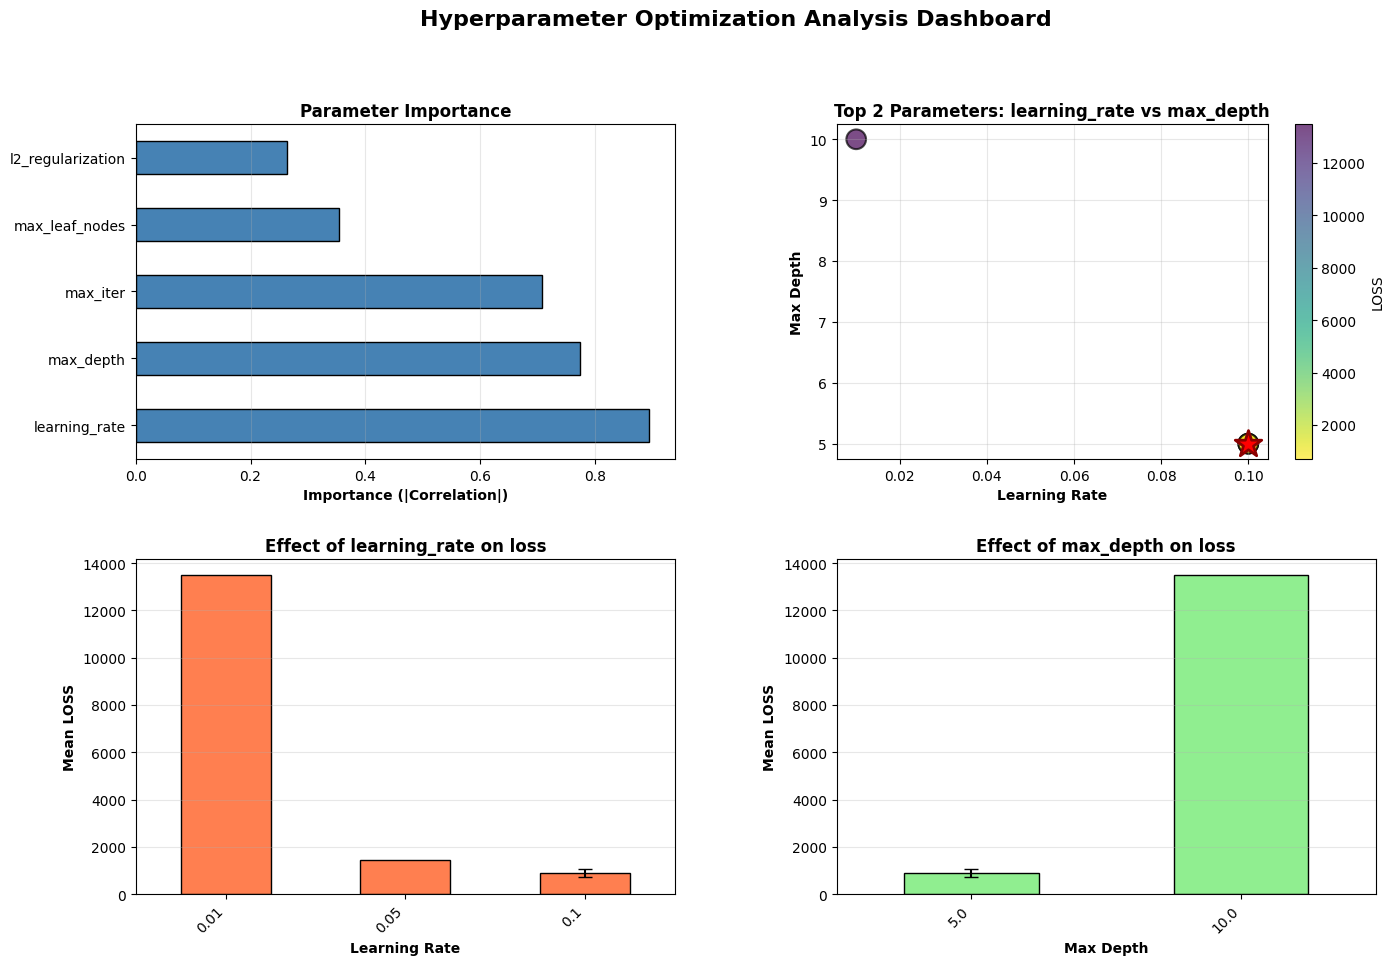

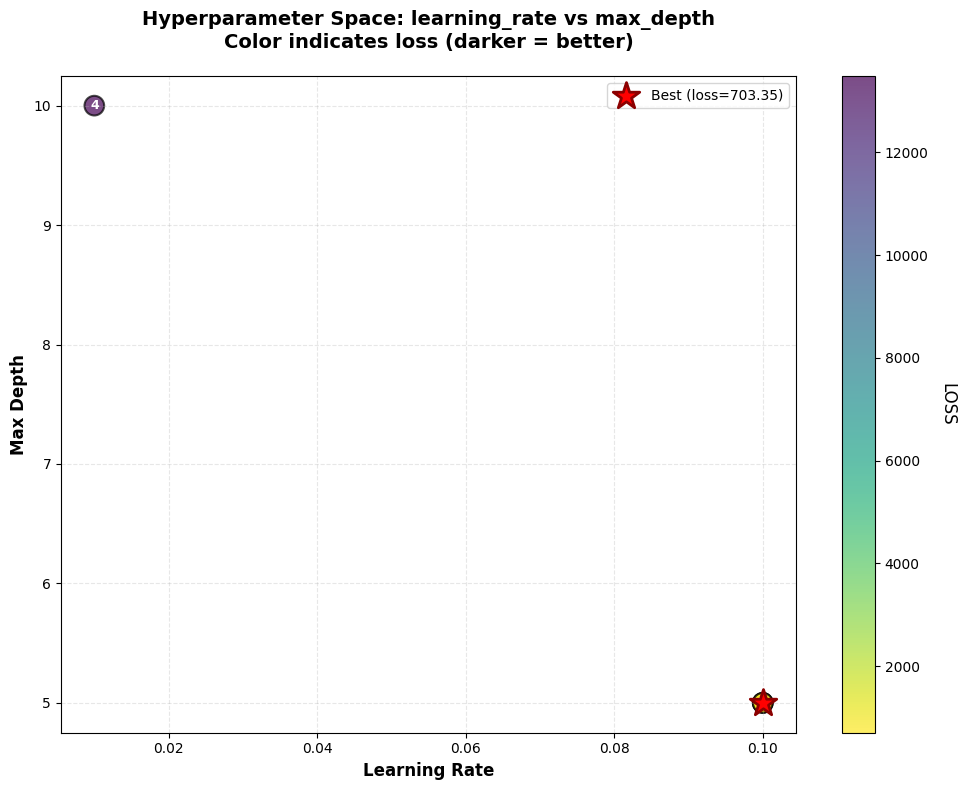

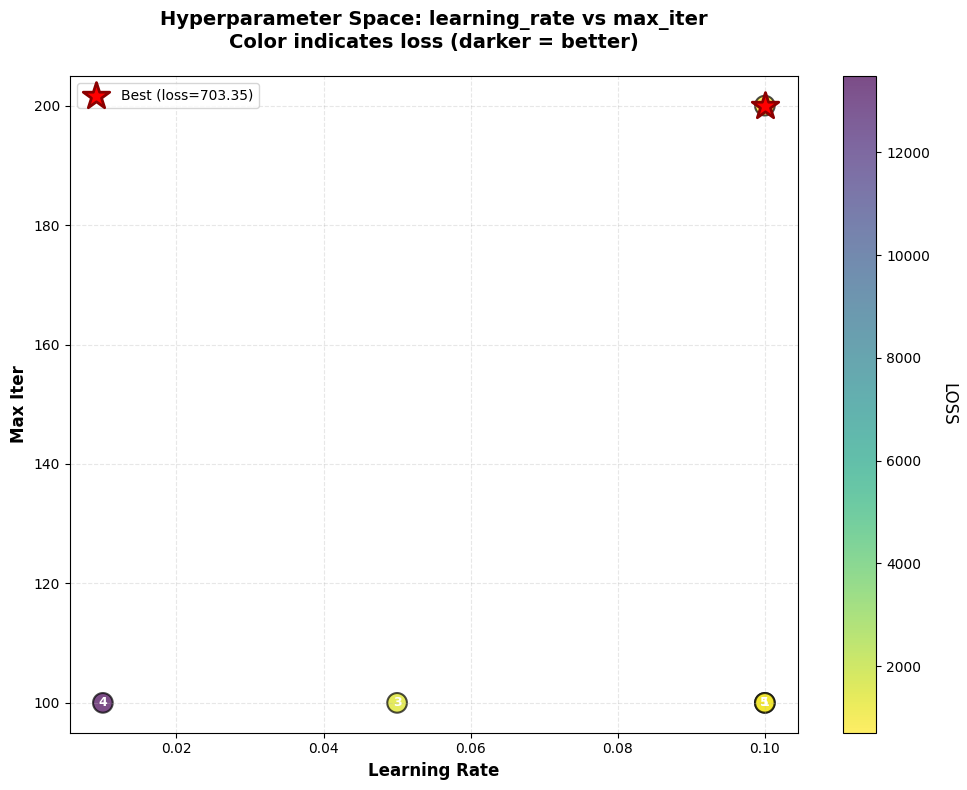

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

def find_most_important_parameters(df, target='loss', method='correlation'):
    """
    Find parameters that have the strongest relationship with loss.
    
    Parameters
    ----------
    df : pd.DataFrame
        Hyperparameter optimization results
    target : str, default='loss'
        Column to analyze (typically 'loss')
    method : str, default='correlation'
        Method to determine importance:
        - 'correlation': Absolute Spearman correlation (handles non-linear)
        - 'variance': Variance in loss for each parameter value
        - 'range': Range of loss values for each parameter
        
    Returns
    -------
    pd.Series
        Importance scores for each parameter (sorted descending)
    """
    # Get parameter columns (exclude metrics)
    param_cols = [col for col in df.columns 
                  if col not in ['loss', 'loss_variance', 'iteration', 'train_time']]
    
    importance = {}
    
    for param in param_cols:
        # Handle NaN values
        valid_mask = df[param].notna() & df[target].notna()
        
        if method == 'correlation':
            # Use Spearman correlation (works for categorical and continuous)
            if df[param].dtype == 'object' or df[param].nunique() < 10:
                # Categorical: encode and correlate
                encoded = pd.factorize(df.loc[valid_mask, param])[0]
                corr, _ = spearmanr(encoded, df.loc[valid_mask, target])
            else:
                # Continuous: direct correlation
                corr, _ = spearmanr(df.loc[valid_mask, param], 
                                   df.loc[valid_mask, target])
            importance[param] = abs(corr)
            
        elif method == 'variance':
            # Variance of loss for each parameter value
            grouped_var = df.groupby(param)[target].var().mean()
            importance[param] = grouped_var
            
        elif method == 'range':
            # Range of loss values when parameter changes
            loss_range = df.groupby(param)[target].mean().max() - \
                        df.groupby(param)[target].mean().min()
            importance[param] = loss_range
    
    return pd.Series(importance).sort_values(ascending=False)


def plot_2d_parameter_space(df, param1, param2, target='loss', 
                           figsize=(10, 8), cmap='viridis_r'):
    """
    Create 2D scatter plot showing how two parameters affect loss.
    
    Parameters
    ----------
    df : pd.DataFrame
        Hyperparameter optimization results
    param1, param2 : str
        Parameter names to plot
    target : str, default='loss'
        Target metric to visualize (color)
    figsize : tuple, default=(10, 8)
        Figure size
    cmap : str, default='viridis_r'
        Colormap (use _r for reversed, so dark = better)
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Handle NaN values
    plot_df = df[[param1, param2, target]].dropna()
    
    # Create scatter plot
    scatter = ax.scatter(
        plot_df[param1], 
        plot_df[param2],
        c=plot_df[target],
        s=200,
        alpha=0.7,
        cmap=cmap,
        edgecolors='black',
        linewidth=1.5
    )
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label(target.upper(), rotation=270, labelpad=20, fontsize=12)
    
    # Highlight best configuration
    best_idx = plot_df[target].idxmin()
    best_point = plot_df.loc[best_idx]
    ax.scatter(
        best_point[param1], 
        best_point[param2],
        s=400,
        marker='*',
        c='red',
        edgecolors='darkred',
        linewidth=2,
        label=f'Best ({target}={best_point[target]:.2f})',
        zorder=5
    )
    
    # Annotate points with iteration number
    for idx, row in plot_df.iterrows():
        if 'iteration' in df.columns:
            label = f"{int(df.loc[idx, 'iteration'])}"
        else:
            label = f"{idx}"
        ax.annotate(
            label,
            (row[param1], row[param2]),
            fontsize=9,
            ha='center',
            va='center',
            color='white',
            weight='bold'
        )
    
    # Labels and title
    ax.set_xlabel(param1.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_ylabel(param2.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_title(f'Hyperparameter Space: {param1} vs {param2}\n'
                 f'Color indicates {target} (darker = better)',
                 fontsize=14, fontweight='bold', pad=20)
    
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    return fig, ax


def create_parameter_analysis_dashboard(df, target='loss'):
    """
    Create comprehensive visualization of parameter importance and interactions.
    
    Parameters
    ----------
    df : pd.DataFrame
        Hyperparameter optimization results
    target : str, default='loss'
        Target metric to analyze
    """
    # Find most important parameters
    importance = find_most_important_parameters(df, target)
    print("Parameter Importance (Spearman Correlation with Loss):")
    print("=" * 60)
    for param, score in importance.items():
        print(f"  {param:.<40} {score:.4f}")
    print()
    
    # Get top 2 parameters
    top_params = importance.index[:2].tolist()
    print(f"\nTop 2 most impactful parameters:")
    print(f"  1. {top_params[0]}")
    print(f"  2. {top_params[1]}")
    print()
    
    # Create multi-panel figure
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
    
    # Panel 1: Parameter importance bar chart
    ax1 = fig.add_subplot(gs[0, 0])
    importance.plot(kind='barh', ax=ax1, color='steelblue', edgecolor='black')
    ax1.set_xlabel('Importance (|Correlation|)', fontweight='bold')
    ax1.set_title('Parameter Importance', fontweight='bold', fontsize=12)
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Panel 2: 2D scatter of top 2 parameters
    ax2 = fig.add_subplot(gs[0, 1])
    plot_df = df[top_params + [target]].dropna()
    scatter = ax2.scatter(
        plot_df[top_params[0]], 
        plot_df[top_params[1]],
        c=plot_df[target],
        s=200,
        alpha=0.7,
        cmap='viridis_r',
        edgecolors='black',
        linewidth=1.5
    )
    best_idx = plot_df[target].idxmin()
    best_point = plot_df.loc[best_idx]
    ax2.scatter(best_point[top_params[0]], best_point[top_params[1]],
                s=400, marker='*', c='red', edgecolors='darkred', 
                linewidth=2, zorder=5)
    plt.colorbar(scatter, ax=ax2, label=target.upper())
    ax2.set_xlabel(top_params[0].replace('_', ' ').title(), fontweight='bold')
    ax2.set_ylabel(top_params[1].replace('_', ' ').title(), fontweight='bold')
    ax2.set_title(f'Top 2 Parameters: {top_params[0]} vs {top_params[1]}',
                  fontweight='bold', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    # Panel 3: Individual parameter effects
    ax3 = fig.add_subplot(gs[1, 0])
    param_data = df.groupby(top_params[0])[target].agg(['mean', 'std', 'count'])
    param_data['mean'].plot(kind='bar', ax=ax3, yerr=param_data['std'],
                            color='coral', edgecolor='black', capsize=5)
    ax3.set_xlabel(top_params[0].replace('_', ' ').title(), fontweight='bold')
    ax3.set_ylabel(f'Mean {target.upper()}', fontweight='bold')
    ax3.set_title(f'Effect of {top_params[0]} on {target}',
                  fontweight='bold', fontsize=12)
    ax3.grid(True, alpha=0.3, axis='y')
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Panel 4: Second parameter effects
    ax4 = fig.add_subplot(gs[1, 1])
    param_data2 = df.groupby(top_params[1])[target].agg(['mean', 'std', 'count'])
    param_data2['mean'].plot(kind='bar', ax=ax4, yerr=param_data2['std'],
                             color='lightgreen', edgecolor='black', capsize=5)
    ax4.set_xlabel(top_params[1].replace('_', ' ').title(), fontweight='bold')
    ax4.set_ylabel(f'Mean {target.upper()}', fontweight='bold')
    ax4.set_title(f'Effect of {top_params[1]} on {target}',
                  fontweight='bold', fontsize=12)
    ax4.grid(True, alpha=0.3, axis='y')
    plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.suptitle('Hyperparameter Optimization Analysis Dashboard',
                 fontsize=16, fontweight='bold', y=0.995)
    
    return fig, importance, top_params


# ============================================================================
# USAGE EXAMPLE
# ============================================================================

# Load your data
df = pd.DataFrame({
    'loss': [995.110296, 703.347862, 1446.656841, 13488.422349, 993.285990],
    'loss_variance': [4734.429570, 2418.791465, 12573.003323, 227871.406609, 6522.367808],
    'iteration': [1, 2, 3, 4, 5],
    'train_time': [2.355983, 3.966343, 7.538664, 4.056260, 2.514577],
    'l2_regularization': [0.0, 0.1, 1.0, 0.0, 0.1],
    'learning_rate': [0.10, 0.10, 0.05, 0.01, 0.10],
    'max_depth': [5.0, 5.0, np.nan, 10.0, 5.0],
    'max_iter': [100, 200, 100, 100, 100],
    'max_leaf_nodes': [31, 31, 63, 31, 31]
})

# Method 1: Quick analysis with dashboard
fig, importance, top_params = create_parameter_analysis_dashboard(df)
plt.savefig('hyperparameter_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Method 2: Create standalone 2D plot of top parameters
fig, ax = plot_2d_parameter_space(df, top_params[0], top_params[1])
plt.savefig('top_2_parameters.png', dpi=300, bbox_inches='tight')
plt.show()

# Method 3: Manual selection of specific parameters
fig, ax = plot_2d_parameter_space(df, 'learning_rate', 'max_iter')
plt.show()